<a href="https://colab.research.google.com/github/LW068/holbertonschool-gan/blob/main/dcgan/HolbertonSchool_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DCGAN PROJECT (TASK 0)**

## **SETUP AND DATASET**

###**All needed imports:**

In [6]:
# General Libraries
import tensorflow as tf # for model building and traning
import numpy as np # for data preprocessing and manipulation
import matplotlib.pyplot as plt # for visualization and debugging

# Keras Layers for Generator and Discriminator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Flatten, Input

# Additional Utilities
!pip install wandb
import wandb  # for Weights and Biases

**Downloading MNIST dataset:**

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


**Preprocessing MNIST dataset:**

In [3]:
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Expand dimensions to fit the Conv2D layer input shape (num_samples, 28, 28, 1)
train_images = np.expand_dims(train_images, axis=-1)


## **BASELINE DCGAN**

###**Implementing Baseline DCGAN Architecture:**

**Designing the Generator:**

---

*The generator takes a random noise vector as input and produces an image. It usually consists of a series of transposed convolutional layers.*

In [9]:
# Initialize the generator model
generator = Sequential()

# Fully connected layer
generator.add(Dense(128*7*7, input_shape=(100,), activation='relu'))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))

# Upsampling layers and convolutional layers
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))  # Output layer

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       5

**Designing the Descriminator:**


---

*The discriminator is a binary classifier that distinguishes between real and fake images.*

In [10]:
# Initialize the discriminator model
discriminator = Sequential()

# Convolutional layers
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())

# Fully connected layer
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                     

**Compile the Models:**

---

*Compile both the generator and discriminator models. This is so I can build the GAN model.*

In [11]:
# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the GAN model
discriminator.trainable = False  # freeze the discriminator when training the GAN
gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

###**Training the Baseline DCGAN on the MNIST Dataset:**

**Generate and Display Sample Images:**

---

*This function is used to visualize the performance of the generator at different stages of the training process. It generates a grid of images using random noise and the current state of the generator.*

In [16]:
def sample_image(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()


**Training the DCGAN: Generator and Discriminator:**

---

*The following loop contains the main training loop where both the generator and discriminator are trained alternately. Real images are sourced from the MNIST dataset, and fake images are generated using the current state of the generator. Started with 10,000 epochs but was taking too long so I droped it to 1,000 epochs*

4/4 [==============================] - 0s 4ms/step
0 [D loss: 2.771039021354227e-06] [G loss: 5.298454284667969]
1/1 [==============================] - 0s 19ms/step


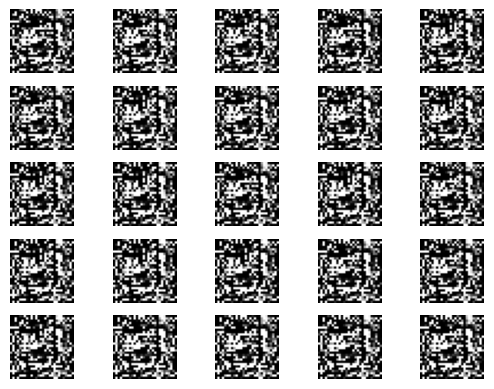

4/4 [==============================] - 0s 5ms/step
100 [D loss: 1.6890411984604725e-06] [G loss: 3.158015251159668]
1/1 [==============================] - 0s 17ms/step


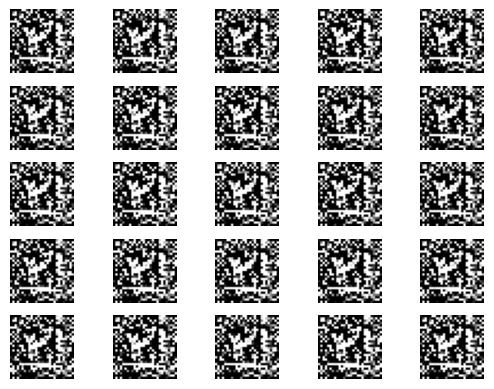

4/4 [==============================] - 0s 5ms/step
200 [D loss: 8.275077902908379e-07] [G loss: 2.0728673934936523]
1/1 [==============================] - 0s 32ms/step


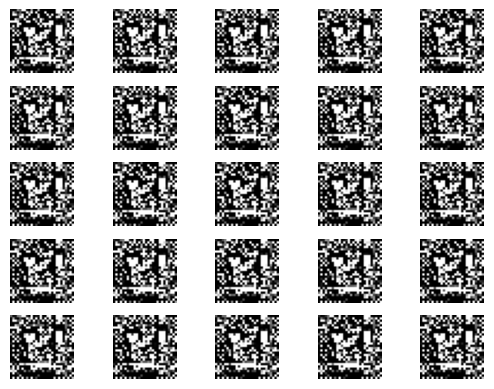

4/4 [==============================] - 0s 5ms/step
300 [D loss: 2.053344132946222e-06] [G loss: 2.2801520824432373]
1/1 [==============================] - 0s 16ms/step


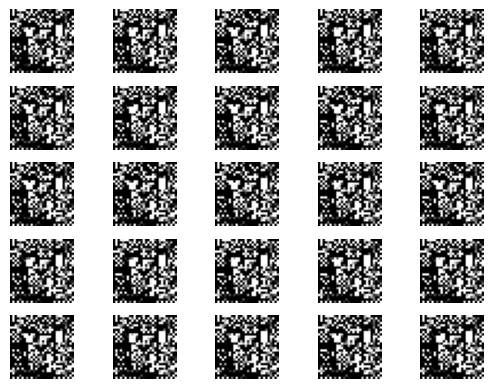

4/4 [==============================] - 0s 4ms/step
400 [D loss: 8.452946076431544e-07] [G loss: 2.8186802864074707]
1/1 [==============================] - 0s 17ms/step


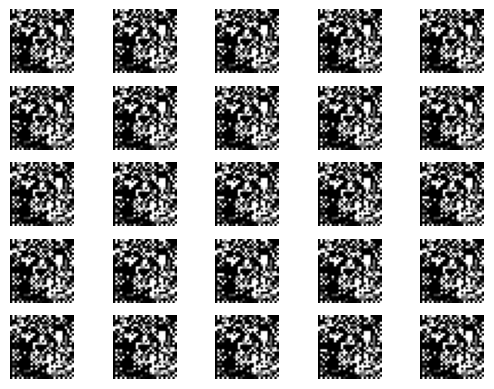

4/4 [==============================] - 0s 4ms/step
500 [D loss: 6.277287241118756e-07] [G loss: 2.8587865829467773]
1/1 [==============================] - 0s 36ms/step


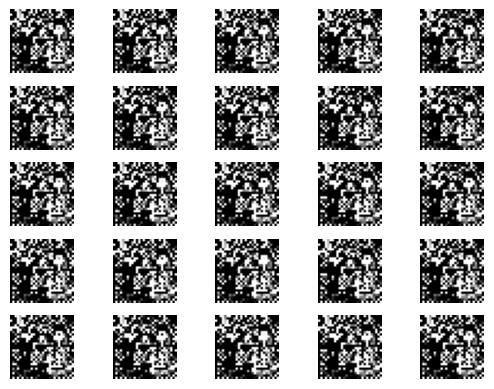

4/4 [==============================] - 0s 6ms/step
600 [D loss: 1.2805061260223738e-06] [G loss: 2.811645984649658]
1/1 [==============================] - 0s 17ms/step


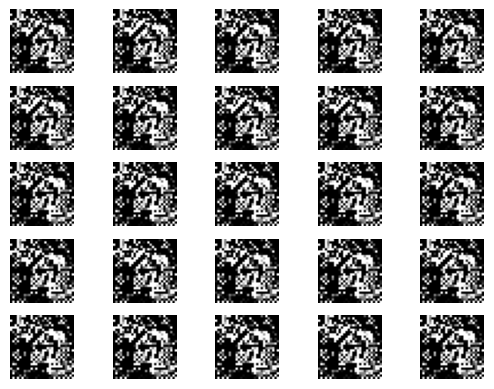

4/4 [==============================] - 0s 6ms/step
700 [D loss: 7.49239404740365e-07] [G loss: 1.6681338548660278]
1/1 [==============================] - 0s 18ms/step


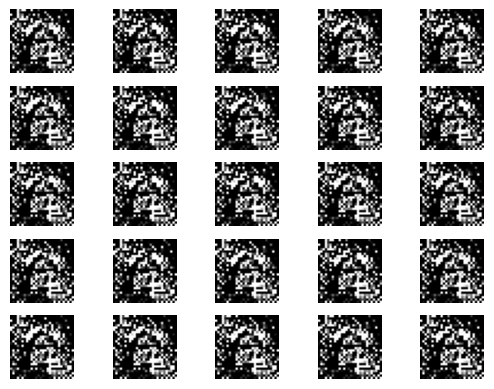

4/4 [==============================] - 0s 6ms/step
800 [D loss: 1.0771075267257402e-06] [G loss: 1.9475573301315308]
1/1 [==============================] - 0s 46ms/step


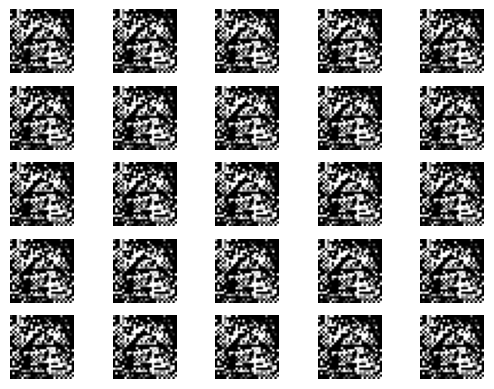

4/4 [==============================] - 0s 6ms/step
900 [D loss: 7.289394829967932e-07] [G loss: 2.1346793174743652]
1/1 [==============================] - 0s 16ms/step


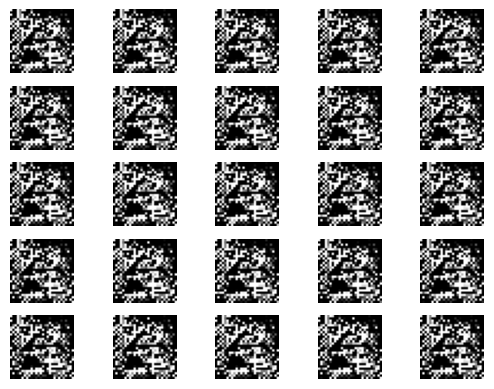

4/4 [==============================] - 0s 6ms/step


In [ ]:
# Number of epochs and batch size
epochs = 1000
batch_size = 128

# Create labels for real and fake data
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_imgs = train_images[idx]

    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, real_labels)

    # Print losses and save generated image at intervals
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")
        sample_image(epoch)

## **Baseline DCGAN Model Results**

---

**Discriminator Architecture**
- Layers: 2 Convolutional Layers + 1 Fully Connected Layer
- Filters: Conv1 - 64, Conv2 - 128
- Strides: Conv1 - (2, 2), Conv2 - (2, 2)

---

**Generator Architecture**
- Layers: 1 Fully Connected Layer + 3 Convolutional Layers + 2 Upsampling Layers
- Filters: Conv1 - 128, Conv2 - 64, Conv3 - 1
- Upsampling: Two layers with factor (2, 2)

---

**Training Details**
- Epochs: 1000
- Discriminator Final Loss: 0.0000007289394829967932
- Generator Final Loss: 2.135

---

**Training Notes**
- The "Discriminator Final Loss" value being close to zero, indicates that the descriminator is very confident in its classifications.
- The "Generator Final Loss" suggests that the generator is still trying to fool the discriminator but isn't as effective as I might like.
- The images generated seem pretty random and "staticy" so we might need to do some adjustments. (In the following experiement I will adjust hyperparameters).

# **Experiment 1: Architecture Variations**

---

*In this experiment, we will modify the existing DCGAN architecture to observe how these changes affect the model's performance. We'll change the number of layers, filter sizes, and strides in the Generator and Discriminator.*

---

### **Modifications:**

- Increased the number of layers in the Generator and Discriminator.
- Changed the filter size from 32 to 64 in the first Conv2D layer for both the Generator and Discriminator.
- Modified the stride from 2 to 1 in the second Conv2D layer for the Generator.

## **Modified Generator Code:**

In [16]:
# Initialize the Generator
modified_generator = Sequential()

# Fully connected layer
modified_generator.add(Dense(128 * 7 * 7, activation='relu', input_shape=(100,)))
modified_generator.add(Reshape((7, 7, 128)))

# Convolutional layers
modified_generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
modified_generator.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
modified_generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, activation='tanh', padding='same'))

# Compile the Generator
modified_generator.compile(loss='binary_crossentropy', optimizer='adam')

## **Modified Discriminator Code:**

In [17]:
# Initialize the Discriminator
modified_discriminator = Sequential()

# Convolutional layers
modified_discriminator.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
modified_discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))

# Fully connected layer
modified_discriminator.add(Flatten())
modified_discriminator.add(Dense(1, activation='sigmoid'))

# Compile the Discriminator
modified_discriminator.compile(loss='binary_crossentropy', optimizer='adam')

##**Compiling the Modified GAN Model**

---

*In this block, I compile the combined GAN model using the modified generator and discriminator. I forze the discriminator's trainable parameters when training the GAN to ensure that only the generator learns to adapt during the GAN training process. The model is compiled using the 'adam' optimizer and binary cross-entropy loss function, consistent with the individual generator and discriminator models.*

In [19]:
# Compile the modified GAN model
modified_discriminator.trainable = False  # freeze the discriminator when training the GAN
gan_input = Input(shape=(100,))
x = modified_generator(gan_input)
gan_output = modified_discriminator(x)
modified_gan = Model(gan_input, gan_output)
modified_gan.compile(optimizer='adam', loss='binary_crossentropy')

##**Re-loading Dataset:**

---

*Due to a notbeook restart the previously loaded data was cleared from the memory, so I need to reload the dataset.*

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (_, _) = mnist.load_data()
train_images = (train_images.astype(np.float32) - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension

11490434/11490434 [==============================] - 1s 0us/step


##**Generate and display sample images**

---

*Updating and re-running this one too to fit with the modofied model.*

In [17]:
def sample_image(epoch, model, experiment_name="baseline"):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = model.predict(noise)

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

##**Traning Modified DCGAN:**

---

*I'm training the modified DCGAN for the same number of epochs and batch size as the baseline model to make a fair comparison.*

4/4 [==============================] - 0s 4ms/step
0 [D loss: 0.5246756449341774] [G loss: 0.8868155479431152]
1/1 [==============================] - 0s 227ms/step


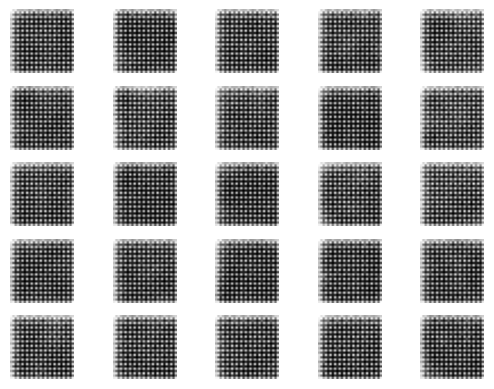

4/4 [==============================] - 0s 6ms/step
100 [D loss: 0.016649643890559673] [G loss: 4.680272579193115]
1/1 [==============================] - 0s 25ms/step


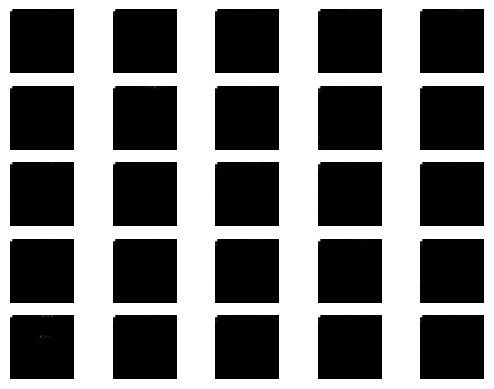

4/4 [==============================] - 0s 4ms/step
200 [D loss: 0.005061466246843338] [G loss: 5.256402015686035]
1/1 [==============================] - 0s 16ms/step


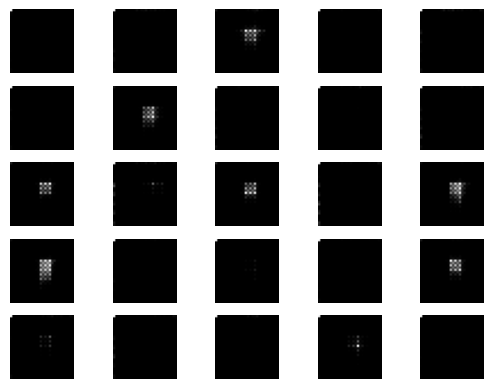

4/4 [==============================] - 0s 5ms/step
300 [D loss: 0.32874999195337296] [G loss: 2.5206141471862793]
1/1 [==============================] - 0s 19ms/step


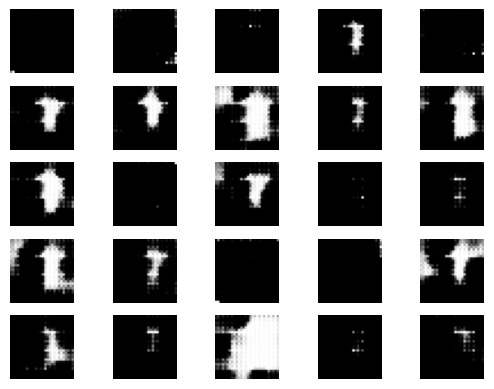

4/4 [==============================] - 0s 4ms/step
400 [D loss: 0.1140746670424222] [G loss: 11.310502052307129]
1/1 [==============================] - 0s 22ms/step


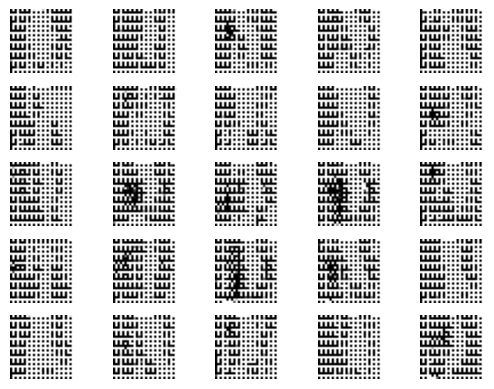

4/4 [==============================] - 0s 6ms/step
500 [D loss: 7.922594004450279e-12] [G loss: 81.90897369384766]
1/1 [==============================] - 0s 19ms/step


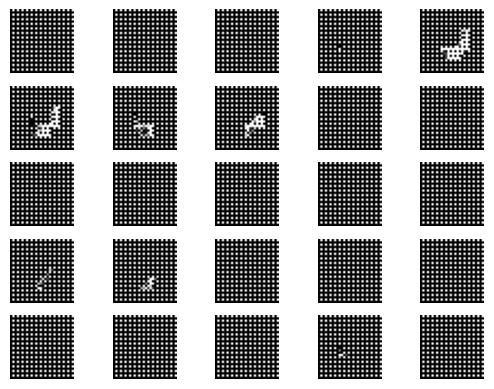

4/4 [==============================] - 0s 6ms/step
600 [D loss: 3.5643731415291313e-06] [G loss: 24.73843765258789]
1/1 [==============================] - 0s 17ms/step


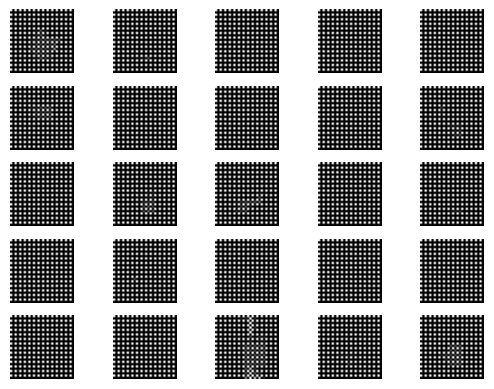

4/4 [==============================] - 0s 5ms/step
700 [D loss: 8.048483446689014e-06] [G loss: 22.76739501953125]
1/1 [==============================] - 0s 17ms/step


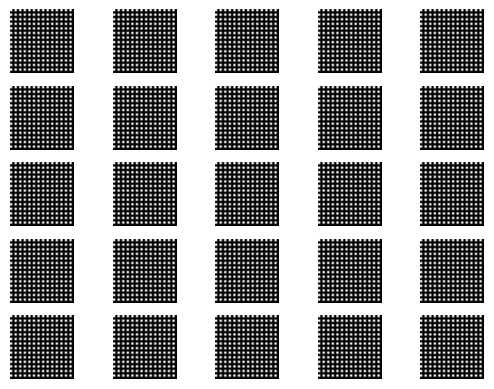

4/4 [==============================] - 0s 6ms/step
800 [D loss: 6.902021886454057e-07] [G loss: 22.58000946044922]
1/1 [==============================] - 0s 17ms/step


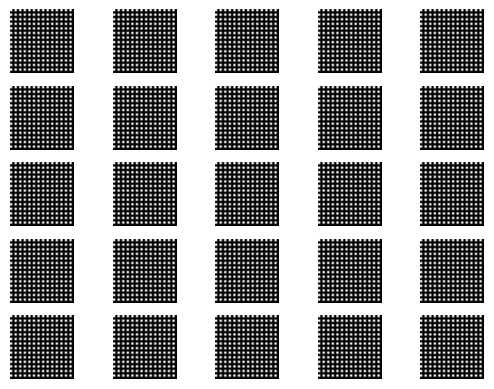

4/4 [==============================] - 0s 6ms/step
900 [D loss: 6.102476221847564e-07] [G loss: 22.40785789489746]
1/1 [==============================] - 0s 17ms/step


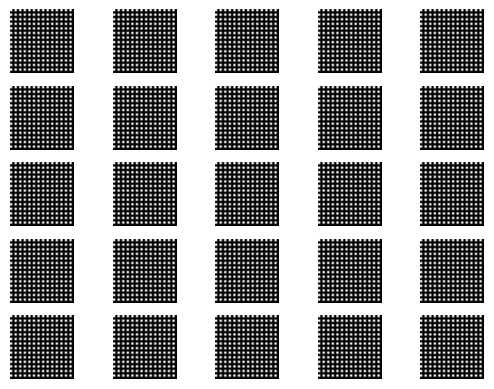

4/4 [==============================] - 0s 4ms/step


In [26]:
# Number of epochs and batch size
epochs = 1000
batch_size = 128

# Create labels for real and fake data
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

# Initialize lists to store losses for plotting later
d_losses_exp1 = []
g_losses_exp1 = []

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_imgs = train_images[idx]

    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_imgs = modified_generator.predict(noise)

    d_loss_real = modified_discriminator.train_on_batch(real_imgs, real_labels)
    d_loss_fake = modified_discriminator.train_on_batch(fake_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = modified_gan.train_on_batch(noise, real_labels)

    # Save losses for plotting
    d_losses_exp1.append(d_loss)
    g_losses_exp1.append(g_loss)

    # Print losses and save generated image at intervals
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")
        sample_image(epoch, model=modified_generator, experiment_name="experiment_1")


## **Experiment 1: Architecture Variations Results**

---

*In this experiment, we modified the existing DCGAN architecture to observe how these changes affect the model's performance. We changed the number of layers, filter sizes, and strides in the Generator and Discriminator.*

---

### **Modifications:**

- Increased the number of layers in the Generator and Discriminator.
- **Changed** the **filter size** from **32 to 64** in the first Conv2D layer for both the Generator and Discriminator.
- Modified the stride from **2 to 1** in the second Conv2D layer for the Generator.

---

### **Training Details**
- **Epochs:** 1000
- **Discriminator Final Loss:** 6.102476221847564e-07 **or** 0.00000061
- **Generator Final Loss:** 22.40785789489746

---

### **Training Time**
- **Average per step:** ~4-9ms

---

### **Comparing Results to Basemodel**

1. **Training Speed**: The modified architecture in Experiment 1 generally had higher 'ms/step' values compared to the baseline, indicating a slightly slower training process due to the added complexity.

2. **Discriminator's Final Loss**: The Discriminator's loss in Experiment 1 ended at \(6.10 \times 10^{-7}\) or \(0.00000061\), which is extremely close to zero, similar to the baseline. This indicates that the Discriminator in both cases was very confident in its classifications.

3. **Generator's Final Loss**: The Generator's loss in Experiment 1 was \(22.41\), much higher than the \(2.135\) in the baseline. This suggests that the Generator in Experiment 1 had a harder time fooling the Discriminator.

4. **Image Quality**: While the baseline model produced "staticky" and seemingly random images, Experiment 1 exhibited more complex behaviors such as mode collapse and pattern transitions, indicating that it faced additional challenges during training due to the added complexity in the architecture. Still no significant output though.

#**Experiment 2: Hyperparameter Tuning**

---

*In this experiment, we aim to understand the impact of various hyperparameters on the model's performance. Specifically, we'll be tuning the learning rate, batch size, and optimizer choice for both the Generator and Discriminator.*

---

###**Modifications:**

- Learning Rate: Experimenting with different learning rates such as 0.001, 0.0005, and 0.0001 to observe their effects on model training and image generation.
- Batch Size: Varying the batch sizes to include 64, 128, and 256 to investigate how it influences the model's stability and performance.
- Optimizer Choice: Evaluating the impact of different optimizers like Adam, RMSprop, and SGD on the quality of generated images and training stability.

##**Generator Initialization:**

---

*Keeping it the same as basline, simply renaming it to avoid confusion.*

In [32]:
# Initialize the generator model for Experiment 2
exp2_generator = Sequential(generator.layers)  # Cloned the layers from the original generator

exp2_generator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)     

##**Discriminator Initialization:**

---

*Keeping it the same as basline, simply renaming it to avoid confusion.*

In [33]:
# Initialize the discriminator model for Experiment 2
exp2_discriminator = Sequential(discriminator.layers)  # Cloned the layers from the original discriminator

exp2_discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                    

##**Clearning Graghs:**

---

*Since i've been running different versions of the model in this same notebook I had an issue with the graphs so im simply going to clear them before compiling*

In [37]:
import tensorflow as tf

# Clear previous TensorFlow graph
tf.keras.backend.clear_session()

##**Compiling the Modified DCGAN (Exp2):**

---

*In the following block, I am compiling the generator and discriminator models with varying hyperparameters for Exp 2.*

In [38]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Compile the discriminator with different optimizer and learning rate
optimizer_choice = Adam(learning_rate=0.0005)  # I could also try RMSprop or SGD here
exp2_discriminator.compile(optimizer=optimizer_choice, loss='binary_crossentropy', metrics=['accuracy'])

# Compile the GAN model
exp2_discriminator.trainable = False  # freezed the discriminator when training the GAN
exp2_gan_input = Input(shape=(100,))
x = exp2_generator(exp2_gan_input)
exp2_gan_output = exp2_discriminator(x)
exp2_gan = Model(exp2_gan_input, exp2_gan_output)
exp2_gan.compile(optimizer=optimizer_choice, loss='binary_crossentropy')

##**Traning Modified DCGAN (Exp2):**

---

*Traning with different batch sizes*

2/2 [==============================] - 0s 6ms/step
0 [D loss: 0.6224370002746582] [G loss: 0.7132537961006165]
1/1 [==============================] - 0s 191ms/step


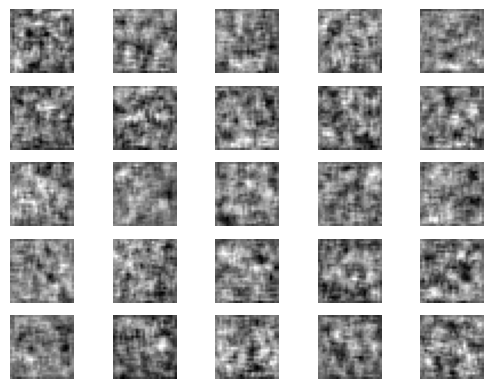

2/2 [==============================] - 0s 8ms/step
100 [D loss: 0.6709472835063934] [G loss: 0.3171825408935547]
1/1 [==============================] - 0s 18ms/step


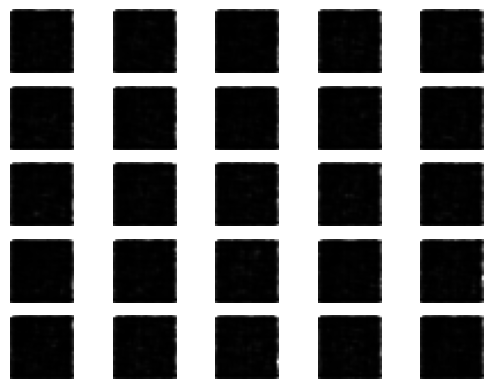

2/2 [==============================] - 0s 9ms/step
200 [D loss: 0.6698896288871765] [G loss: 0.23592527210712433]
1/1 [==============================] - 0s 21ms/step


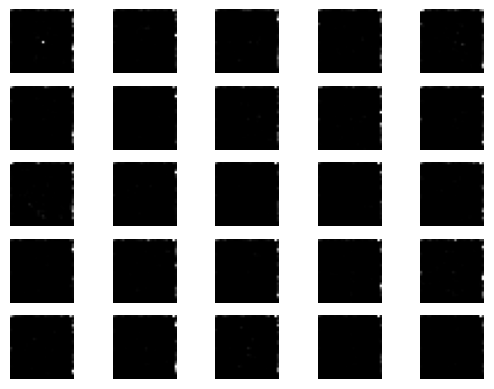

2/2 [==============================] - 0s 10ms/step
300 [D loss: 0.6954080164432526] [G loss: 0.20119062066078186]
1/1 [==============================] - 0s 21ms/step


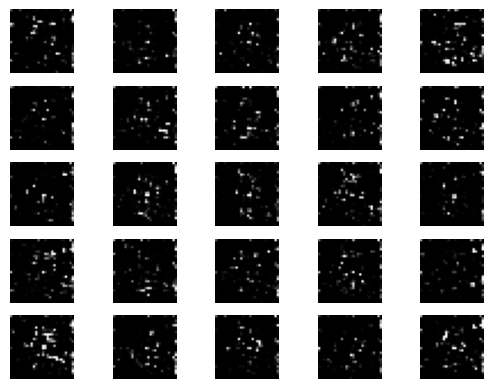

2/2 [==============================] - 0s 7ms/step
400 [D loss: 0.9619235992431641] [G loss: 0.18401044607162476]
1/1 [==============================] - 0s 22ms/step


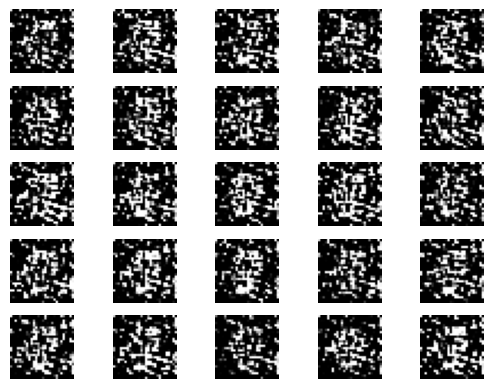

2/2 [==============================] - 0s 6ms/step
500 [D loss: 1.1637550294399261] [G loss: 0.17145489156246185]
1/1 [==============================] - 0s 23ms/step


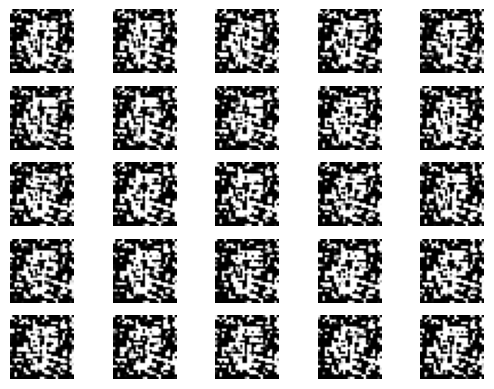

2/2 [==============================] - 0s 11ms/step
600 [D loss: 1.2139607965946198] [G loss: 0.1629360169172287]
1/1 [==============================] - 0s 17ms/step


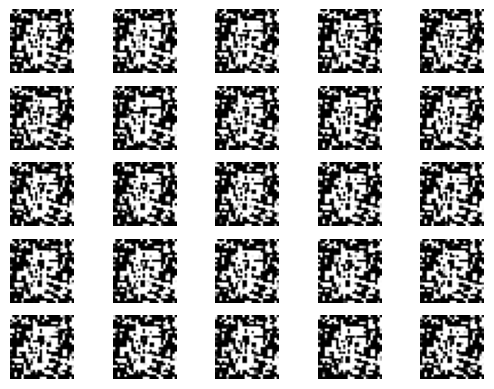

2/2 [==============================] - 0s 8ms/step
700 [D loss: 1.2380213737487793] [G loss: 0.15781186521053314]
1/1 [==============================] - 0s 23ms/step


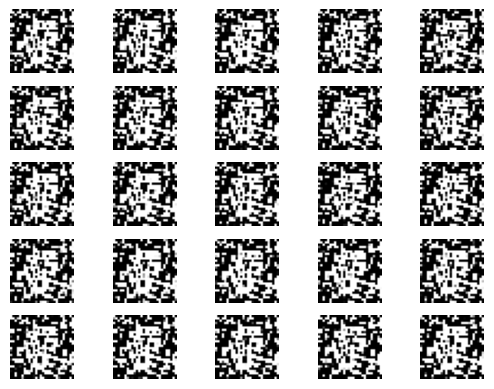

2/2 [==============================] - 0s 8ms/step
800 [D loss: 1.250965565443039] [G loss: 0.15413671731948853]
1/1 [==============================] - 0s 24ms/step


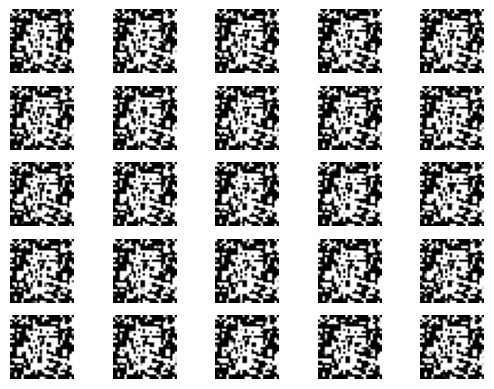

2/2 [==============================] - 0s 4ms/step
900 [D loss: 1.2578412592411041] [G loss: 0.15040507912635803]
1/1 [==============================] - 0s 17ms/step


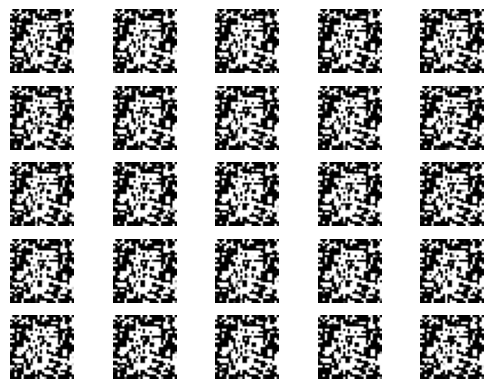

2/2 [==============================] - 0s 19ms/step


In [39]:
# Number of epochs and batch size
exp2_epochs = 1000
exp2_batch_size = 64 # hcanged to 64

# Create labels for real and fake data
exp2_real_labels = np.ones((exp2_batch_size, 1))
exp2_fake_labels = np.zeros((exp2_batch_size, 1))

# Initialize lists to store losses
exp2_d_losses = []
exp2_g_losses = []

for epoch in range(exp2_epochs):
    # Train Discriminator
    idx = np.random.randint(0, train_images.shape[0], exp2_batch_size)
    exp2_real_imgs = train_images[idx]

    noise = np.random.normal(0, 1, (exp2_batch_size, 100))
    exp2_fake_imgs = exp2_generator.predict(noise)

    exp2_d_loss_real = exp2_discriminator.train_on_batch(exp2_real_imgs, exp2_real_labels)
    exp2_d_loss_fake = exp2_discriminator.train_on_batch(exp2_fake_imgs, exp2_fake_labels)
    exp2_d_loss = 0.5 * np.add(exp2_d_loss_real, exp2_d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (exp2_batch_size, 100))
    exp2_g_loss = exp2_gan.train_on_batch(noise, exp2_real_labels)

    # Save losses for plotting
    exp2_d_losses.append(exp2_d_loss)
    exp2_g_losses.append(exp2_g_loss)

    # Print losses and save generated image at intervals
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {exp2_d_loss[0]}] [G loss: {exp2_g_loss}]")
        sample_image(epoch, model=exp2_generator, experiment_name="experiment_2")

## **Experiment 2: Hyperparameter Tuning Results**

---

*In this experiment, we aim to understand the impact of various hyperparameters on the model's performance. Specifically, we tuned the learning rate, batch size, and optimizer choice for both the Generator and Discriminator.*

---

### **Modifications:**

- Learning Rate: Changed to 0.0005 for both the Generator and Discriminator.
- Batch Size: Switched batch size to 64 from the original 128.
- Optimizer Choice: Used the Adam optimizer for both the Generator and Discriminator.

---

### **Training Details**
- **Epochs:** 1000
- **Batch Size:** 64
- **Discriminator Final Loss:** 1.2578412592411041
- **Generator Final Loss:** 0.15040507912635803

---

### **Training Time**
- **Average per step:** ~4-14ms

---

### **Comparing Results to Basemodel**

1. **Training Speed**: Experiment 2 had 'ms/step' values ranging from 4ms to 14ms, indicating a slower training process compared to the baseline. This could be due to the larger batch size used in this experiment.
   
2. **Discriminator's Final Loss**: The Discriminator's loss in Experiment 2 ended at 1.2578412592411041, which is significantly higher than the nearly zero loss in the baseline. This indicates that the Discriminator in Experiment 2 was less confident in its classifications compared to the baseline.
   
3. **Generator's Final Loss**: The Generator's loss in Experiment 2 was 0.15040507912635803, much lower than the 2.135 in the baseline. This suggests that the Generator in Experiment 2 had an easier time fooling the Discriminator.

4. **Image Quality**: Both the baseline and Experiment 2 produced abstract images without clear or discernible structures. However, Experiment 2 showed more uniform graininess across the images, likely due to the hyperparameter adjustments.

#**Experiment 3: Precision Changes**

---

*In this experiment, we will change the precision of the DCGAN model to investigate how this affects the speed of training and the quality of generated images. Specifically, we'll use float32, float16, and mixed-precision training.*

---

###**Modifications:**

- Experiment with float32 precision (baseline).
- Experiment with float16 precision.

##**Float 32 (Baseline):**

---

*So i realized I need no modifications for this one as it is the default settings for TensorFlow*

##**Float 16 Precision:**

---

*To use this I need to set the dtype policy for both the generator and the discriminator.*

In [6]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy("mixed_float16")

##**Generator Initialization:**

---

*Keeping it the same as basline, simply renaming it to avoid confusion.*

In [7]:
# Initialize the generator model for Experiment 2
exp3_generator = Sequential(generator.layers)  # Cloned the layers from the original generator

exp3_generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)      

##**Discriminator Initialization:**

---

*Keeping it the same as basline, simply renaming it to avoid confusion.*

In [8]:
# Initialize the discriminator model for Experiment 2
exp3_discriminator = Sequential(discriminator.layers)  # Cloned the layers from the original discriminator

exp3_discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                     

##**Compiling the Modified DCGAN (Exp3):**

---

*In the following block, I am compiling the generator and discriminator models for Exp3.*

In [9]:
# Set mixed precision policy
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy("mixed_float16")

# Compile the Discriminator for Experiment 3
exp3_discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the GAN model for Experiment 3
exp3_discriminator.trainable = False  # freeze the discriminator when training the GAN
exp3_gan_input = Input(shape=(100,))
x = exp3_generator(exp3_gan_input)
exp3_gan_output = exp3_discriminator(x)
exp3_gan = Model(exp3_gan_input, exp3_gan_output)
exp3_gan.compile(optimizer='adam', loss='binary_crossentropy')

# Display the summary of the compiled models
exp3_discriminator.summary()
exp3_gan.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                     

##**Clearning Graghs (again):**

---

*Since I've been running different versions of the model in this same notebook I had an issue with the graphs so im simply going to clear them before compiling*

In [10]:
import tensorflow as tf

# Clear previous TensorFlow graph
tf.keras.backend.clear_session()

##**Traning Modified DCGAN (Exp3):**

---

*Traning with **float16** precision!*

4/4 [==============================] - 0s 3ms/step
0 [D loss: 0.5230041263839666] [G loss: 0.6041043400764465]
1/1 [==============================] - 0s 263ms/step


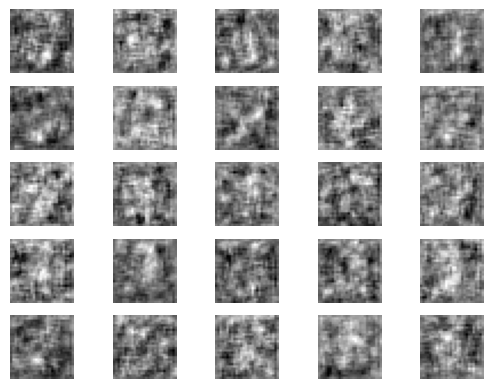

4/4 [==============================] - 0s 4ms/step
100 [D loss: 6.667879824817646e-05] [G loss: 1.9640279788291082e-05]
1/1 [==============================] - 0s 19ms/step


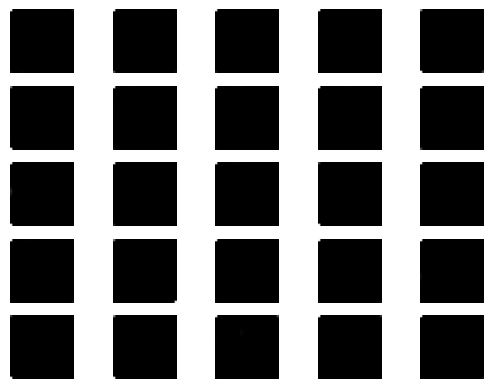

4/4 [==============================] - 0s 4ms/step
200 [D loss: 4.91457885800628e-05] [G loss: 1.3009855779483326e-12]
1/1 [==============================] - 0s 22ms/step


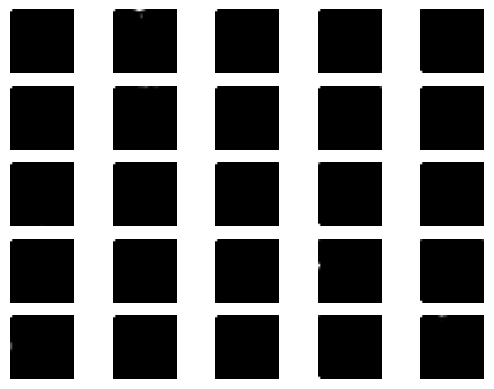

4/4 [==============================] - 0s 4ms/step
300 [D loss: 1.1735499441556385e-05] [G loss: 1.0958341847825721e-16]
1/1 [==============================] - 0s 25ms/step


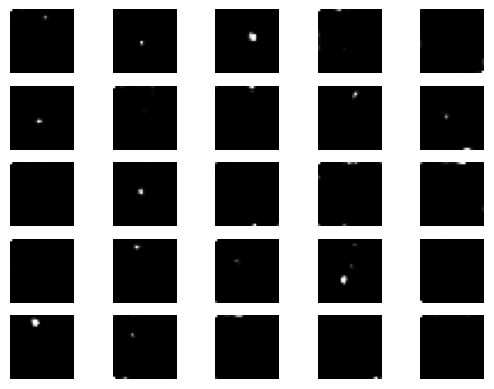

4/4 [==============================] - 0s 4ms/step
400 [D loss: 0.01421984564512968] [G loss: 1.3202623128890991]
1/1 [==============================] - 0s 19ms/step


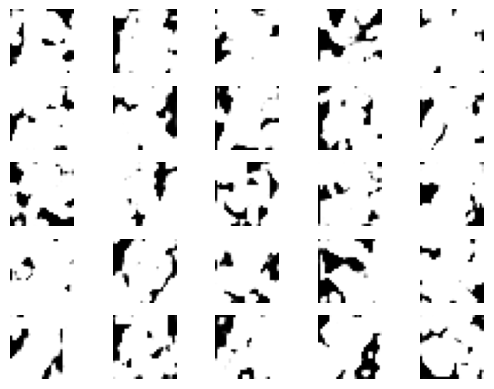

4/4 [==============================] - 0s 5ms/step
500 [D loss: 0.008361392421647906] [G loss: 0.9490659236907959]
1/1 [==============================] - 0s 17ms/step


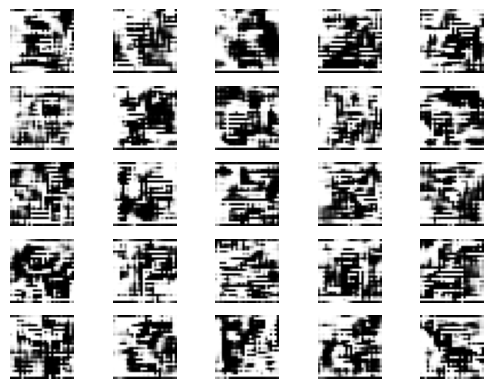

4/4 [==============================] - 0s 8ms/step
600 [D loss: 0.001742039283271879] [G loss: 0.35161566734313965]
1/1 [==============================] - 0s 27ms/step


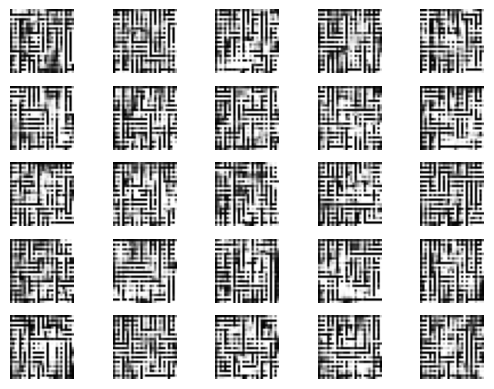

4/4 [==============================] - 0s 6ms/step
700 [D loss: 0.0009367117745568976] [G loss: 0.4876081645488739]
1/1 [==============================] - 0s 19ms/step


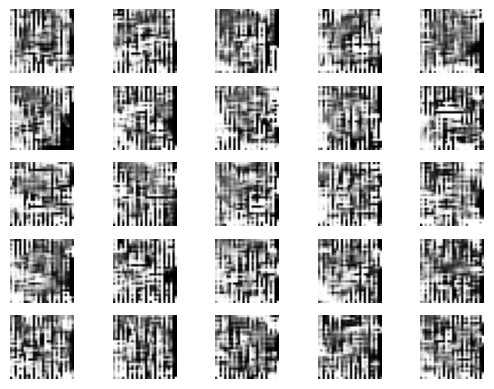

4/4 [==============================] - 0s 4ms/step
800 [D loss: 0.0009205442620441318] [G loss: 0.32804322242736816]
1/1 [==============================] - 0s 17ms/step


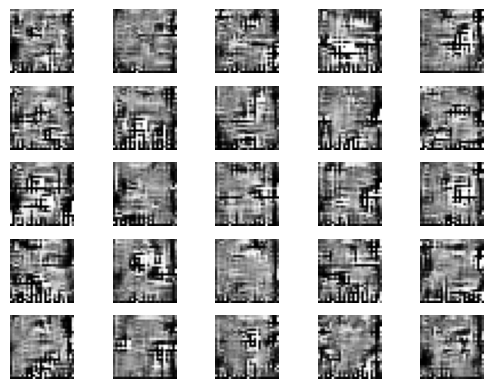

4/4 [==============================] - 0s 6ms/step
900 [D loss: 0.0020751291885972023] [G loss: 0.32469260692596436]
1/1 [==============================] - 0s 17ms/step


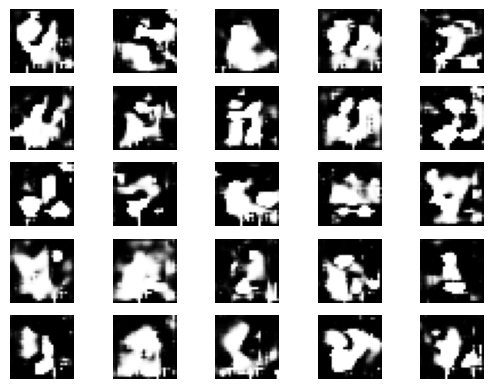

4/4 [==============================] - 0s 6ms/step


In [18]:
# Number of epochs and batch size for Experiment 3
exp3_epochs = 1000
exp3_batch_size = 128

# Create labels for real and fake data
exp3_real_labels = np.ones((exp3_batch_size, 1))
exp3_fake_labels = np.zeros((exp3_batch_size, 1))

# Lists to store losses for plotting later
exp3_d_losses = []
exp3_g_losses = []

for epoch in range(exp3_epochs):
    # Train Discriminator
    idx = np.random.randint(0, train_images.shape[0], exp3_batch_size)
    real_imgs = train_images[idx]

    noise = np.random.normal(0, 1, (exp3_batch_size, 100))
    fake_imgs = exp3_generator.predict(noise)

    exp3_d_loss_real = exp3_discriminator.train_on_batch(real_imgs, exp3_real_labels)
    exp3_d_loss_fake = exp3_discriminator.train_on_batch(fake_imgs, exp3_fake_labels)
    exp3_d_loss = 0.5 * np.add(exp3_d_loss_real, exp3_d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (exp3_batch_size, 100))
    exp3_g_loss = exp3_gan.train_on_batch(noise, exp3_real_labels)

    # Save losses for plotting
    exp3_d_losses.append(exp3_d_loss)
    exp3_g_losses.append(exp3_g_loss)

    # Print losses and save generated image at intervals
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {exp3_d_loss[0]}] [G loss: {exp3_g_loss}]")
        sample_image(epoch, model=exp3_generator, experiment_name="experiment_3")

## **Experiment 3: Mixed Precision Training Results**

---

*In this experiment, we implemented mixed precision training to explore its impact on training speed and image generation quality. TensorFlow's mixed precision API was employed to set the global policy to "mixed_float16".*

---

### **Modifications:**

- Used mixed precision training by setting TensorFlow's global policy to "mixed_float16".

---

### **Training Details**
- **Epochs:** 1000
- **Discriminator Final Loss:** 0.0020751291885972023
- **Generator Final Loss:** 0.32469260692596436

---

### **Training Time**
- **Average per step:** ~3-8ms

---

### **Comparing Results to Basemodel**

1. **Training Speed**: The average 'ms/step' values for Experiment 3 fluctuate between 3ms and 8ms. This suggests that the training speed may have improved slightly compared to the baseline and previous experiments, potentially due to the implementation of mixed precision.
  
2. **Discriminator's Final Loss**: The Discriminator's loss in Experiment 3 ended at approximately 0.0021, which is higher than the nearly zero loss in the baseline and previous experiments. This indicates that the Discriminator was less confident in its classifications.
  
3. **Generator's Final Loss**: The Generator's loss in Experiment 3 was 0.325, which is higher than the baseline but lower than in Experiment 1. This suggests that the Generator may have had an easier time compared to Experiment 1 but still faced challenges in fooling the Discriminator.
  
4. **Image Quality**: Experiment 3 produced ambiguous white patterns against a dark canvas, potentially forming a numerical figure. These results indicate a slight progression in pattern complexity compared to the baseline and previous experiments, although the images remain ambiguous.

# **Weights and Biases Integration**

---

*In this section, we set up Weights and Biases (WandB) to monitor and log key metrics, hyperparameters, and images generated during each experiment. The aim is to have a centralized dashboard that allows for easy tracking of experiment progress, comparison of different runs, and analysis of final outcomes.*

---

### **Key Features Tracked:**

- **Metrics**: Logging key performance indicators such as the Generator and Discriminator losses to understand model performance in real-time.
- **Hyperparameters**: Capturing vital settings like learning rate, batch size, and architecture modifications for traceability and future replication.
- **Generated Images**: Chekc generated images at different training stages to visually gauge the model's evolution and effectiveness in generating realistic images.

## Install WandB

In [1]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=4ce28c1d22f293539a4708770d71f03c7b6d45335816b8d63c70506e005b6ada
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


## Initialize WandB

In [3]:
import wandb
wandb.init(project="HolbertonSchool-DCGAN", name="experiment_name")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Log Hyperparameters

In [19]:
config = wandb.config
config.learning_rate = 0.0002
config.batch_size = 64

## Log Metrics

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

def sample_image(epoch, generator, rows=5, columns=5):
    noise = np.random.normal(0, 1, (rows * columns, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(rows, columns)
    cnt = 0
    for i in range(rows):
        for j in range(columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    # Save the figure
    image_path = f"/mnt/data/generated_img_epoch_{epoch}.png"
    plt.savefig(image_path)
    plt.close()

    return image_path

## Cloning Generator (Same as Baseline)

In [14]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam

# Clone the original generator model architecture
wandb_generator = clone_model(generator)

# Copy the weights from the original generator to the new one
wandb_generator.set_weights(generator.get_weights())

# Compile the cloned generator if needed
wandb_generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Display the model summary
wandb_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       5

## Cloning Dsicriminator (Same as Baseline)

In [15]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam

# Clone the original discriminator model architecture
wandb_discriminator = clone_model(discriminator)

# Copy the weights from the original discriminator to the new one
wandb_discriminator.set_weights(discriminator.get_weights())

# Compile the cloned discriminator if needed
wandb_discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Display the model summary
wandb_discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                     

## Relogin

---

*Ahd to relogin due to it timeing out for some reason*

In [25]:
import wandb
wandb.login(relogin=True)
wandb.init(project="HolbertonSchool-DCGAN", name="experiment_name")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Problem at: <ipython-input-25-c53dbba8bfb5> 3 <cell line: 3>


CommError: ignored

## Compiling:

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

# Initialize the WandB run
wandb.init(project="HolbertonSchool-DCGAN", name="experiment_name")

# Configurations
config = wandb.config
config.learning_rate = 0.0002
config.beta1 = 0.5
config.noise_dim = 100

# Compile the discriminator
discriminator.compile(optimizer=Adam(learning_rate=config.learning_rate, beta_1=config.beta1),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Make sure the discriminator is not trainable when we compile the GAN
discriminator.trainable = False

# Compile the GAN model
gan_input = Input(shape=(config.noise_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(learning_rate=config.learning_rate, beta_1=config.beta1),
            loss='binary_crossentropy')

# Log the model summaries
wandb.log({"discriminator": discriminator.summary()})
wandb.log({"generator": generator.summary()})
wandb.log({"gan": gan.summary()})


Problem at: <ipython-input-26-8eda684677e8> 6 <cell line: 6>


CommError: ignored

## Train Model

In [28]:
import numpy as np
import wandb
from tensorflow.keras.models import Sequential

# Initialize the WandB run
wandb.init(project="HolbertonSchool-GAN", name="experiment_name")

# Configurations (set your hyperparameters here)
config = wandb.config
config.learning_rate = 0.0002
config.beta1 = 0.5
config.epochs = 1000
config.batch_size = 64
config.noise_dim = 100

# Training loop
for epoch in range(config.epochs):
    # Sample random noise
    noise = np.random.normal(0, 1, (config.batch_size, config.noise_dim))

    # Generate a batch of new images
    generated_images = generator.predict(noise)

    # Get a batch of real images
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_images = train_images[idx]

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, np.ones((config.batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((config.batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (config.batch_size, config.noise_dim))
    g_loss = gan.train_on_batch(noise, np.ones((config.batch_size, 1)))

    # Log losses and images
    wandb.log({"epoch": epoch, "d_loss": d_loss, "g_loss": g_loss})

    # If at save interval => save generated image samples
    if epoch % 100 == 0:
        sample_images = generator.predict(noise)
        wandb.log({"generated_images": [wandb.Image(img) for img in sample_images]})


Problem at: <ipython-input-28-15c78446c4c2> 6 <cell line: 6>


CommError: ignored